# 1. AWS Data Wrangler를 이용한 Data load

* https://github.com/awslabs/aws-data-wrangler
* https://aws-data-wrangler.readthedocs.io

AWS Data Wrangler는 오픈 소스 Python 패키지로 Pandas 라이브러리의 기능을 AWS를 연결하는 DataFrames 및 AWS 데이터 관련 서비스 (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight 등)로 확장합니다.

Pandas, Apache Arrow, Boto3, s3fs, SQLAlchemy, Psycopg2 및 PyMySQL과 같은 다른 오픈 소스 프로젝트를 기반으로 구축 된 Data Lakes, Data Warehouses 및 Databases의 데이터로드 / 언로드와 같은 일반적인 ETL 작업을 실행하는 추상 기능을 제공합니다.

In [1]:
%store -r

In [2]:
import sys

In [3]:
!{sys.executable} -m pip install -q awswrangler==1.2.0

In [4]:
import os
import boto3
import sagemaker
import pandas as pd

import awswrangler as wr

sess   = sagemaker.Session()
role = sagemaker.get_execution_role()

## 1 ) Push-Down Filters를 이용한 S3에서 Parquet 쿼리

S3의 prefix 또는 S3객체 경로의 리스트에서 Apache Parquet 파일을 읽습니다. 
Dataset의 개념은 Partitioning과 카탈로그통합과 같이 복잡한 특성을 가능하게 합니다.

dataset (bool) : 만약 True이면 컬럼으로 모든 관련된 partitions을 로드하여 단순 파일이 아닌 parquet dataset으로 읽습니다.

In [5]:
df = wr.s3.read_parquet(s3_path_parquet,
                        filters=[[("product_category", "=", "Digital_Software")],
                                 [("product_category", "=", "Digital_Video_Games")]],
                        dataset=True)
df.shape

(102084, 16)

In [6]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],4,0,0,N,Y,Four Stars,So far so good,2015,2015-08-31,Digital_Software
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015,2015-08-31,Digital_Software
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],1,1,2,N,Y,One Star,Please cancel.,2015,2015-08-31,Digital_Software
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015,2015-08-31,Digital_Software
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015,2015-08-31,Digital_Software


Text(0, 0.5, 'Review Count')

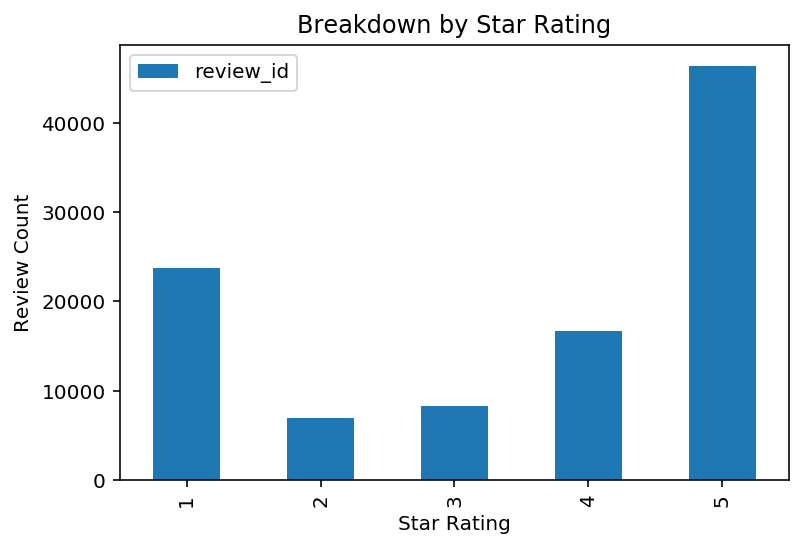

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

df[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='Breakdown by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')

# Balance the Dataset

In [8]:
from sklearn.utils import resample

five_star_df = df.query('star_rating == 5', engine='python')
four_star_df = df.query('star_rating == 4', engine='python')
three_star_df = df.query('star_rating == 3', engine='python')
two_star_df = df.query('star_rating == 2', engine='python')
one_star_df = df.query('star_rating == 1', engine='python')

# Check which sentiment has the least number of samples
minority_count = min(five_star_df.shape[0], 
                     four_star_df.shape[0], 
                     three_star_df.shape[0], 
                     two_star_df.shape[0], 
                     one_star_df.shape[0]) 

five_star_df = resample(five_star_df,
                        replace = False,
                        n_samples = minority_count,
                        random_state = 27)

four_star_df = resample(four_star_df,
                        replace = False,
                        n_samples = minority_count,
                        random_state = 27)

three_star_df = resample(three_star_df,
                        replace = False,
                        n_samples = minority_count,
                        random_state = 27)

two_star_df = resample(two_star_df,
                        replace = False,
                        n_samples = minority_count,
                        random_state = 27)

one_star_df = resample(one_star_df,
                        replace = False,
                        n_samples = minority_count,
                        random_state = 27)

df_balanced = pd.concat([five_star_df, four_star_df, three_star_df, two_star_df, one_star_df])
df_balanced = df_balanced.reset_index(drop=True)

df_balanced.shape

(34450, 16)

Text(0, 0.5, 'Review Count')

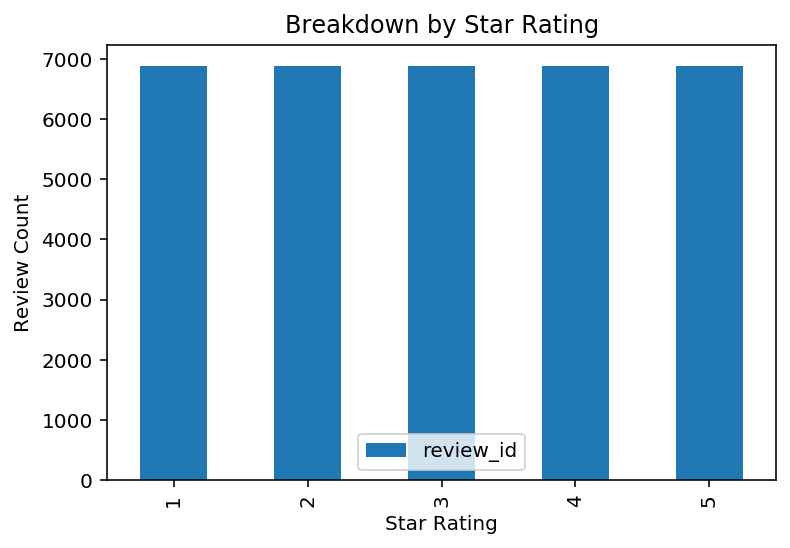

In [9]:
df_balanced[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='Breakdown by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')

In [10]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,25580275,RDKF6NPWA0I0Q,B008S0IMCC,534964191,Quicken Deluxe 2013,5,1,1,N,Y,Good decision,"I used Quicken years ago, but not for a long t...",2013,2013-09-16,Digital_Software
1,US,44261501,RQ5IGCO7KUIKV,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],5,0,0,N,N,"Free does not make it best, its just better th...","From my first computer, with little exception,...",2014,2014-06-03,Digital_Software
2,US,45909911,R15CKN4MMQGWE3,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],5,0,0,N,N,Great!!,My internet runs smoothly and avast keeps me s...,2014,2014-01-21,Digital_Software
3,US,1481455,R1ATHWANWYJAJA,B00B1TG1GQ,186552705,Microsoft Project 2013 (1PC/1User),5,2,2,N,Y,No problems here!!,I was skeptical upon reading some of the revie...,2014,2014-11-26,Digital_Software
4,US,52904840,R3Q5ZQPKRSEAFY,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],5,0,0,N,N,A Top Notch Anti-Virus,A Top Notch Anti-Virus. Nowhere near as memory...,2014,2014-05-30,Digital_Software


# Split the Data into Train, Validation, and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, 
                                        test_size=0.10,
                                        stratify=df_balanced['star_rating'])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout,
                                          test_size=0.50, 
                                          stratify=df_holdout['star_rating'])


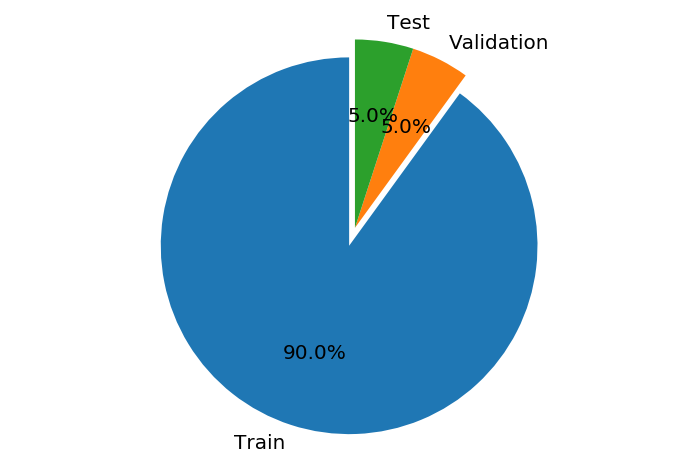

In [12]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Train', 'Validation', 'Test']
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

plt.show()

# Show 90% Train Data Split

In [13]:
df_train.shape

(31005, 16)

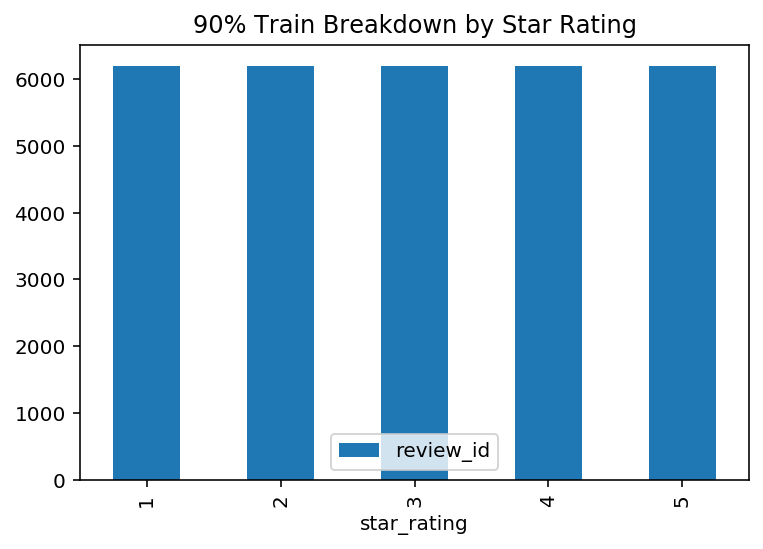

In [14]:
df_train[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='90% Train Breakdown by Star Rating')

# Show 5% Validation Data Split

In [15]:
df_validation.shape

(1722, 16)

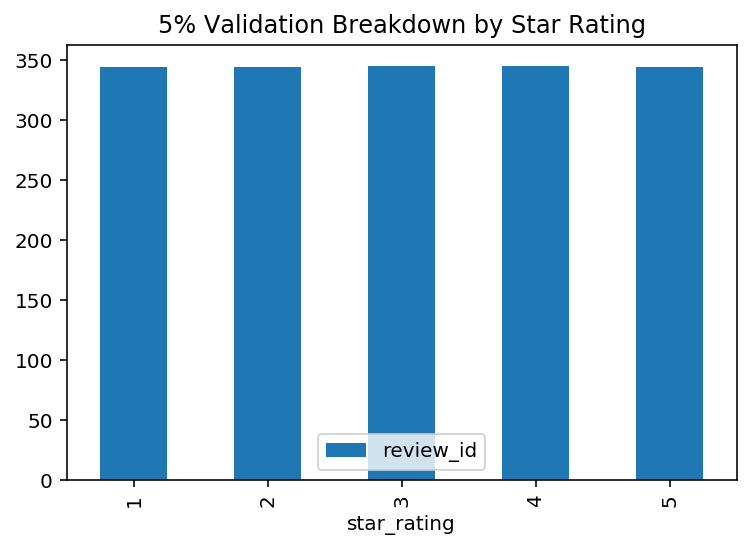

In [16]:
df_validation[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='5% Validation Breakdown by Star Rating')

# Show 5% Test Data Split

In [17]:
df_test.shape

(1723, 16)

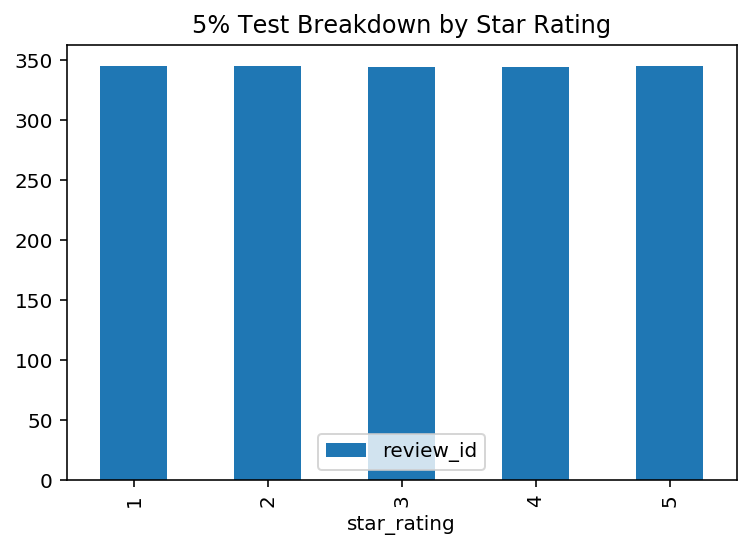

In [18]:
df_test[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='5% Test Breakdown by Star Rating')

# Select `star_rating` and `review_body` for Training

In [19]:
df_train = df_train[['star_rating', 'review_body']]
df_train.shape

(31005, 2)

In [20]:
df_train.head(5)

,star_rating,review_body
19336,3,I bought Quickbooks for my new notebook comput...
943,5,Have had Quicken for many years. This program...
11328,4,For sure you will be able to organize yourself...
33693,1,I've been a Quicken user since the 80s. The p...
22707,2,"I've been a user of Quicken since 2010, and ha..."


In [21]:
df_train = df_train[['star_rating', 'review_body']]

In [22]:
df_train.head(5)

,star_rating,review_body
19336,3,I bought Quickbooks for my new notebook comput...
943,5,Have had Quicken for many years. This program...
11328,4,For sure you will be able to organize yourself...
33693,1,I've been a Quicken user since the 80s. The p...
22707,2,"I've been a user of Quicken since 2010, and ha..."


# Write a Train CSV with Header for AutoPilot 

In [23]:
data_dir='./data'

In [24]:
!rm -rf $data_dir
!mkdir $data_dir

In [25]:
header_train_path = os.path.join(data_dir,'amazon_reviews_us_Digital_Software_v1_00_header.csv')
df_train.to_csv(header_train_path, index=False, header=True)

# Upload Train Data to S3 for AutoPilot

In [26]:
train_s3_prefix = 'data'
header_train_s3_uri = sess.upload_data(path=header_train_path, key_prefix=train_s3_prefix)
header_train_s3_uri

's3://sagemaker-ap-northeast-2-322537213286/data/amazon_reviews_us_Digital_Software_v1_00_header.csv'

In [27]:
!aws s3 ls $header_train_s3_uri

2020-07-30 11:33:42   13650145 amazon_reviews_us_Digital_Software_v1_00_header.csv


# Write a CSV With No Header for Comprehend 

In [28]:
noheader_train_path = os.path.join(data_dir,'amazon_reviews_us_Digital_Software_v1_00_noheader.csv')
df_train.to_csv(noheader_train_path, index=False, header=False)

# Upload Train Data to S3 for Comprehend

In [29]:
train_s3_prefix = 'data'
noheader_train_s3_uri = sess.upload_data(path=noheader_train_path, key_prefix=train_s3_prefix)
noheader_train_s3_uri

's3://sagemaker-ap-northeast-2-322537213286/data/amazon_reviews_us_Digital_Software_v1_00_noheader.csv'

In [30]:
!aws s3 ls $noheader_train_s3_uri

2020-07-30 11:33:43   13650121 amazon_reviews_us_Digital_Software_v1_00_noheader.csv


# Store the location of our train data in our notebook server to be used next

In [31]:
%store header_train_s3_uri

Stored 'header_train_s3_uri' (str)


In [32]:
%store noheader_train_s3_uri

Stored 'noheader_train_s3_uri' (str)


In [33]:
%store

Stored variables and their in-db values:
data_bucket                                  -> 'sagemaker-ap-northeast-2-322537213286'
database_name                                -> 'awsdb'
header_train_s3_uri                          -> 's3://sagemaker-ap-northeast-2-322537213286/data/a
job_bucket                                   -> 'sagemaker-experiments-ap-northeast-2-322537213286
max_seq_length                               -> 128
noheader_train_s3_uri                        -> 's3://sagemaker-ap-northeast-2-322537213286/data/a
processed_test_data_s3_uri                   -> 's3://sagemaker-ap-northeast-2-322537213286/sagema
processed_train_data_s3_uri                  -> 's3://sagemaker-ap-northeast-2-322537213286/sagema
processed_validation_data_s3_uri             -> 's3://sagemaker-ap-northeast-2-322537213286/sagema
region_name                                  -> 'ap-northeast-2'
role                                         -> 'arn:aws:iam::322537213286:role/service-role/sagem
s3_de